In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Drive-by-Wire Node Testing

Udacity provided the `dbw_test` node to check the outputs of the DBW node against those from a reference databag, but they did not provide the reference databag. They did however provide a databag that included the required data (and other data) later in the course, so we've used that data here to calibrate the DBW node.

This required some minor mods to the `dbw_test` node to (1) also log the time, which makes it easier to plot the data, and (2) only play the required topics from the rosbag.

### Load Data from `dbw_test` Node

In [3]:
def parse_stamp(x):
    return pd.to_datetime(float(x), unit='s', utc=True)

def read_data(test_folder):
    cmds = ['steer', 'throttle', 'brake']
    csvs = [
        pd.read_csv(
            os.path.join(test_folder, cmd + 's.csv'),
            date_parser = parse_stamp,
            parse_dates = ['time'])
        for cmd in cmds
    ]
    for csv, cmd in zip(csvs, cmds):
        csv['cmd'] = cmd
        csv['t'] = (csv['time'] - csv['time'].min()) \
            .map(lambda x: x.total_seconds())
    data = pd.concat(csvs)
    return data.melt(
        id_vars=['cmd', 't'],
        value_vars=['actual', 'proposed'])

## With Settings for Simulator

After tuning the DBW node for the simulator, the outputs were as follows.

The steering and brake (after normalization to account for the fact that we are still sending brake commands as torques) look vaguely OK, but we seem to be understeering slightly.

As has been noted many times on Slack, the throttle commands required in the simulator are much higher than those on Carla.

In [4]:
data_1 = read_data('dbw_test_1')

In [5]:
data_1[0:10]

,cmd,t,variable,value
0,steer,0.000000,actual,-0.000000
1,steer,0.039943,actual,-0.000000
2,steer,0.060657,actual,-0.000000
3,steer,0.100011,actual,-0.000000
4,steer,0.140248,actual,-0.000000
5,steer,0.160509,actual,-0.504755
6,steer,0.200895,actual,-0.533435
7,steer,0.240220,actual,-0.601215
8,steer,0.260009,actual,-0.658473
9,steer,0.300985,actual,-0.692828


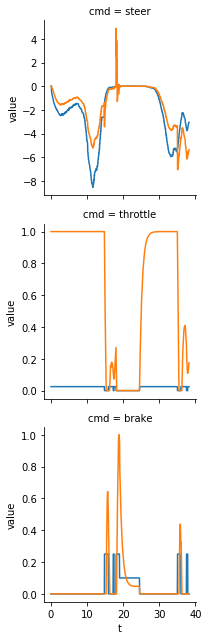

In [6]:
def plot_cmds(data):
    # The brake commands in the reference dataset are percentages,
    # but we're using the torque values. Normalize to get something
    # like a comparable scale.
    data = data.copy()
    is_brake = (data['cmd'] == 'brake') & (data['variable'] == 'proposed')
    data.loc[is_brake, 'value'] = data[is_brake]['value'] / data[is_brake]['value'].max()
    
    g = sns.FacetGrid(
        data, row='cmd', hue='variable', sharex=True, sharey=False)
    g = g.map(plt.plot, 't', 'value')
plot_cmds(data_1)

### With Corrections

For now I'm going to hope that the steering angles are close enough; it can always steer a bit longer and/or take the curve slightly wider.

To correct for the large difference in throttle, we've added a `max_throttle` parameter to the `dbw_node` that is `1` in simulation and `0.025` for Carla.

In [7]:
data_2 = read_data('dbw_test_2')

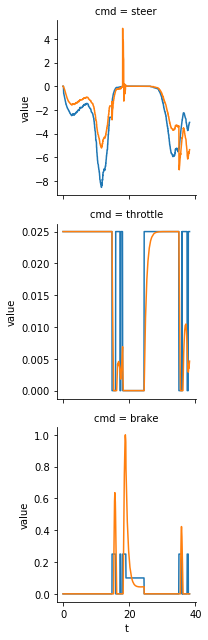

In [8]:
plot_cmds(data_2)